# Microgrid performance simulation

Case of Microgrid project with *wind* and *solar* sources,
plus a *battery* and a *dispatchable generator*:

<img alt='schematic of a microgrid with wind' src='./images/microgrid.png' style='width:25em'>

Demo of main data structures and functions of [Microgrids.py](https://github.com/Microgrids-X/Microgrids.py).
Main steps are:

1. Describe the Microgrid project and components (including loading time series data)
2. Simulation the Microgrid
3. Analyze simulation results (technical and economic)

Also, at the end of this notebook, there is an interactive simulation using [ipywidgets](https://ipywidgets.readthedocs.io).

In [71]:
try: # Install microgrids package in JupyterLite (if run in JupyterLite)
    import piplite
    await piplite.install(['microgrids', 'ipywidgets'])
except ImportError:
    pass

In [72]:
import numpy as np
from matplotlib import pyplot as plt

import microgrids as mgs

## Load time series data

Read load and solar data:
- Load: real consumption data at an hourly timestep from the [Ushant island](https://en.wikipedia.org/wiki/Ushant) in 2016
- Solar and wind data comes from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html). See [data/SOURCES.md](data/SOURCES.md).

Remarks:
- do not hesitate to use *your own data file(s)*. You need three vectors of 24×365 = 8760 points.
- if you run this notebook from JupyterLite (i.e. the demo embedded in a web page), you can upload a data file from the [file browser](https://jupyterlab.readthedocs.io/en/stable/user/files.html) in the left sidebar.

In [73]:
from pathlib import Path
folder = Path('.')
datapath = folder / 'data' / 'Ouessant_data_2016.csv'

In [74]:
data = np.loadtxt(datapath, delimiter=',', skiprows=2, usecols=(1,2,4))

# Split load, solar and wind data:
Pload = data[:,0] # kW
Ppv1k = data[:,1] / 1000; # convert to kW/kWp
wind_speed = data[:,2]; # m/s

# Calibrate wind speed data against a mast measurement 
ws_gain = 1.059 # ratio of Mast's mean /PVGIS' mean
wind_speed = ws_gain*wind_speed

print('Time series statistics:')
print(f'- Load: min {np.min(Pload):.0f}, mean {np.mean(Pload):.0f}, max {np.max(Pload):.0f} kW')
print(f'- PV capacity factor: {np.mean(Ppv1k):.2%}') # yearly capacity factor of 12% (quite low in 2016 in Ouessant)
print(f'- Wind speed: mean {np.mean(wind_speed):.2f} m/s')

Time series statistics:
- Load: min 294, mean 773, max 1707 kW
- PV capacity factor: 11.83%
- Wind speed: mean 8.03 m/s


Display load time series

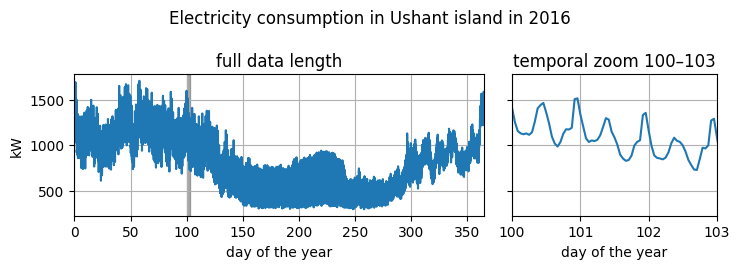

In [75]:
td = np.arange(len(Pload))/24 # time in days

def plot_ts_zoom(t, ts, zoom, color='C1', title='', xlabel='', ylabel=''):
    """helper: plot time series with a temporal zoom"""
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7.5,2.7), sharey=True,
                                   gridspec_kw={'width_ratios': [2,1]})
    ax1.plot(t, ts, color=color)
    ax1.axvspan(zoom[0], zoom[1], color='k', alpha=0.3)
    ax2.plot(t, ts, color=color)
    ax2.set_xlim(zoom[0], zoom[1])

    ax1.grid(True)
    ax2.grid(True)
    fig.suptitle(title)
    ax1.set_xlim(t[0], t[-1])
    ax1.set(
        title='full data length',
        xlabel=xlabel,
        ylabel=ylabel
    )
    ax2.set(
        title=f'temporal zoom {zoom[0]}–{zoom[1]}',
        xlabel=xlabel,
    )
    fig.tight_layout()
    return fig, (ax1, ax2)


fig, (ax1, ax2) = plot_ts_zoom(
    td, Pload,
    zoom=(100,103), color='tab:blue',
    title='Electricity consumption in Ushant island in 2016',
    xlabel='day of the year', ylabel='kW'
)
plt.show()

### Generate wind power capacity factor time series from wind speed

We use the generic wind power curve model `WindPower.capacity_from_wind` to transform wind speed time series into a capacity factor time series (normalized power).
The main parameters of this power curve are:
- Rotor swept area (m²), i.e. derived from the rotor diameter with $S=\pi(D/2)^2$
- Turbine Specific Power (W/m²), i.e. rated power compared to area

Wind turbine parameters used here are fitted to an [EWT 900 kW DW52](https://ewtdirectwind.com/products/dw52/):

In [76]:
S_D52 = np.pi * (52/2)**2 # rotor swept area m²
TSP_D52 = 900e3/S_D52 # W/m²
v_out = 25.0 # m/s
Cp_D52, α_D52 = 0.521, 3.1 # fitted from actual power curve

In [77]:
cf_wind = mgs.WindPower.capacity_from_wind(wind_speed, TSP_D52, Cp_D52, v_out, α_D52)
np.mean(cf_wind) # annual capacity factor
print(f'Wind  capacity factor: {np.mean(cf_wind):.2%}') # yearly capacity factor of 12% (quite low in 2016 in Ouessant)

Wind  capacity factor: 39.70%


## Microgrid description

Describe the Microgrid project and its components using dedicated data structures

### Project parameters

Financial parameters like discount rate, as well as technical details like the timestep of input data.

In [78]:
lifetime = 25 # yr
discount_rate = 0.05
timestep = 1. # h

project = mgs.Project(lifetime, discount_rate, timestep)

### Dispatchable generator (Diesel)

Used as last recourse, when there is not enough production from renewables and the battery is empty

In [79]:
power_rated_gen = 1800.  # rated power (kW) → /2 to see some load shedding
# fuel parameters:
fuel_intercept = 0.0 # fuel curve intercept (l/h/kW_max)
fuel_slope = 0.240 # fuel curve slope (l/h/kW)
# prices
fuel_price = 1. # fuel price ($/l)
investment_price_gen = 400. # initial investiment price ($/kW)
om_price_gen = 0.02 # operation & maintenance price ($/kW/h of operation)
lifetime_gen = 15000. # generator lifetime (h)

generator = mgs.DispatchableGenerator(power_rated_gen,
    fuel_intercept, fuel_slope, fuel_price,
    investment_price_gen, om_price_gen,
    lifetime_gen
)

### Battery energy storage

Used as a buffer between the renewables production and the consumption

In [80]:
energy_rated_sto = 5000. # rated energy capacity (kWh)
investment_price_sto = 350. # initial investiment price ($/kWh)
om_price_sto = 10. # operation and maintenance price ($/kWh/y)
lifetime_sto = 15. # calendar lifetime (y)
lifetime_cycles = 3000. # maximum number of cycles over life (1)
# Parameters with default values
charge_rate = 1.0 # max charge power for 1 kWh (kW/kWh = h^-1)
discharge_rate = 1.0 # max discharge power for 1 kWh (kW/kWh = h^-1)
loss_factor_sto = 0.05 # linear loss factor α (round-trip efficiency is about 1 − 2α) ∈ [0,1]

battery = mgs.Battery(energy_rated_sto,
    investment_price_sto, om_price_sto,
    lifetime_sto, lifetime_cycles,
    charge_rate, discharge_rate,
    loss_factor_sto)

### Photovoltaic generation

Used in priority to feed the load (along wind power). PV generation is assumed proportional to the irradiance data load in previous section.

In [81]:
power_rated_pv = 3000. # rated power (kW)
irradiance = Ppv1k # global solar irradiance incident on the PV array (kW/m²)
investment_price_pv = 1200. # initial investiment price ($/kW)
om_price_pv = 20.# operation and maintenance price ($/kW/y)
lifetime_pv = 25. # lifetime (y)
# Parameters with default values
derating_factor_pv = 1.0 # derating factor (or performance ratio) ∈ [0,1]

photovoltaic = mgs.Photovoltaic(power_rated_pv, irradiance,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv)

Display PV production time series (which is proportional to the rated power of the plant `power_rated_pv`)
- PV production is computed by calling the `production` method on the `Photovoltaic` instance

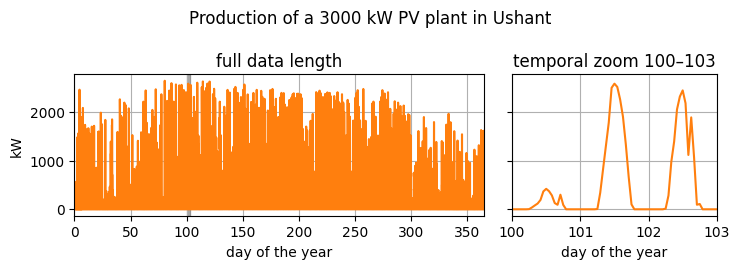

In [82]:
fig, (ax1, ax2) = plot_ts_zoom(
    td, photovoltaic.production(),
    zoom=(100,103), color='tab:orange',
    title=f'Production of a {power_rated_pv:.0f} kW PV plant in Ushant',
    xlabel='day of the year', ylabel='kW'
)
plt.show()

### Wind power generation

Used in priority to feed the load along solar power.

The simple wind power model use the fixed capacity factor data derived from wind speed in the previous section.

In [83]:
power_rated_wind = 900. # rated power (kW)
investment_price_wind = 3500. # initial investiment price ($/kW)
om_price_wind = 100.# operation and maintenance price ($/kW/y)
lifetime_wind = 25. # lifetime (y)

windgen = mgs.WindPower(power_rated_wind, cf_wind,
    investment_price_wind, om_price_wind,
    lifetime_wind)

Display wind power time series:
- Wind production is computed by calling the `production` method on the `WindPower` instance

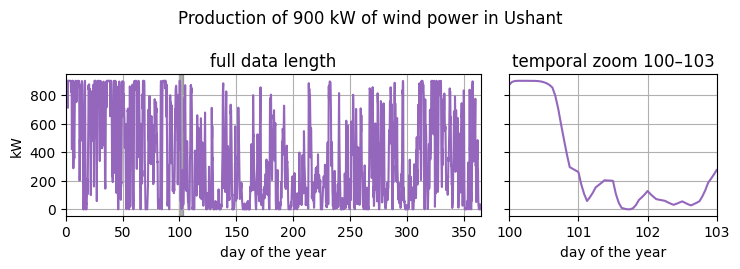

In [84]:
fig, (ax1, ax2) = plot_ts_zoom(
    td, windgen.production(),
    zoom=(100,103), color='tab:purple',
    title=f'Production of {power_rated_wind:.0f} kW of wind power in Ushant',
    xlabel='day of the year', ylabel='kW'
)
plt.show()

### Microgrid data structure

the `Microgrid` data structure groups:
- project parameters
- load time series
- all components:
  - generator
  - battery
  - renewable power generators (as a dictionnary)

In [85]:
microgrid = mgs.Microgrid(project, Pload,
    generator, battery, {
        'Solar': photovoltaic,
        'Wind': windgen
    }
)

Display the microgrid structure and ratings

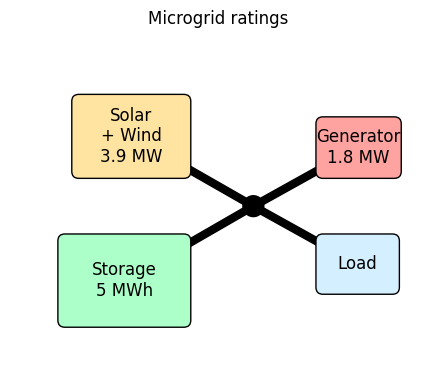

In [86]:
mgs.plotting.plot_ratings(microgrid, 'MW', xlim=(-3.5,2.5), ylim=(-2.5,2.5))
plt.show()

## Simulate the microgrid

Launched with the `Microgrid.simulate` method:

In [87]:
####steve oper_stats, mg_costs = microgrid.simulate()

In details, the simulation is done in two stages:

1. simulate the **operation**, in particular the energy flow at an hourly timestep between components: 
    - generates operation statistics as `OperationStats` data structure
    - records trajectories of operation variables. Optional since it makes the simulation about 80% slower
2. evaluate the **economic cost** of the project, based on its description and on the operation statistics: 
    - generates cost data as `MicrogridCosts` data structure

These successive stages can be run manually with their dedicated functions (see `simulate` code).

### First: Operation simulation (`sim_operation`)

Simulation *without trajectories*, just to get the operation statisics

In [88]:
oper_stats = mgs.sim_operation(microgrid)

In [89]:
%timeit mgs.sim_operation(microgrid) # 45 ms in JupyterLite, 11 ms with regular Jupyter/Python 3.11 kernel

15.7 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Simulation *with trajectories* (about twice slower)

In [90]:
oper_traj = mgs.TrajRecorder()
oper_stats = mgs.sim_operation(microgrid, oper_traj)

In [91]:
%timeit mgs.sim_operation(microgrid, oper_traj) # 82 ms in JupyterLite, 22 ms with regular Jupyter/Python kernel

30.1 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Second: Economic evaluation (`sim_economics`)

In [92]:
mg_costs = mgs.sim_economics(microgrid, oper_stats)

In [93]:
%timeit mgs.sim_economics(microgrid, oper_stats) # 60 µs in JupyterLite, 22 µs with regular Jupyter/Python kernel

38.6 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Analyze Microgrid simulation results

### Technical performance

Operation statistics are in `oper_stats` (`OperationStats` data structure) with fields such as `renew_rate` (fraction of renewables in the energy mix), `shed_rate` (fraction of shed, i.e. unserved load)...

In [94]:
print(f'Load shedding rate: {oper_stats.shed_rate:.1%}')
print(f'Renewable rate: {oper_stats.renew_rate:.1%}')

Load shedding rate: 0.0%
Renewable rate: 75.3%


The energy mix found in `oper_stats` can be displayed graphically:

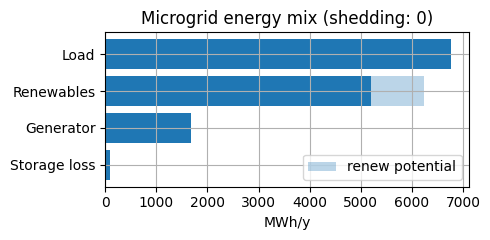

In [95]:
mgs.plotting.plot_energy_mix(microgrid, oper_stats)
plt.show()

### Economic performance

Economic performance indicators are stored in `mg_costs` (as a `MicrogridCosts` data structure). This structure contains the following fields:
- two highlevel cost indicators: Net present Cost `npc` and Levelized Costs of Electricity `lcoe`
- a break down of cost factors for the entire project in `system`: initial investment, fuel... (as a `CostFactors` structure)
- a detailed break down of cost factors for each component in `generator`, `storage`, `nondispatchables['name']`... (also as `CostFactors` structures)

In [96]:
print(f'Levelized Cost of Electricity: {mg_costs.lcoe:.3f} $/kWh')
print(f'Net Present Cost: {mg_costs.npc/1e6:.2f} M$ (over {project.lifetime} years at {project.discount_rate:.0%} discount rate)')

Levelized Cost of Electricity: 0.229 $/kWh
Net Present Cost: 21.89 M$ (over 25 years at 5% discount rate)


Break down of cost factors for the entire project:

In [97]:
mg_costs.system

CostFactors(total=21890027.729086526, investment=9220000.0, replacement=2788220.2252348172, om=4498223.347698843, fuel=5658609.470860712, salvage=-275025.3147078488)

Break down of cost factors for each nondispatchable power sources (i.e. renewables), with the same names as in `microgrid.nondispatchables`:

In [98]:
mg_costs.nondispatchables

{'Solar': CostFactors(total=4445636.673962685, investment=3600000.0, replacement=0.0, om=845636.6739626852, fuel=0.0, salvage=-0.0),
 'Wind': CostFactors(total=4418455.010944027, investment=3150000.0, replacement=0.0, om=1268455.0109440277, fuel=0.0, salvage=-0.0)}

Remark: `npc` is equal to `system.total`

Individual cost factors can be accessed by field names. For examples fuel costs for the dispatchable generator:

In [99]:
round(mg_costs.generator.fuel/1e6, ndigits=2) # M$

5.66

#### Cost table

The costs for all components and for all factors can be display in one compact table with `costs_table`. The lower left corner is the Net Present Cost.

In [100]:
cmat, cmat_rows, cmat_cols = mg_costs.costs_table()
print(f'Cost matrix. columns: {cmat_cols}')
print(f'  rows: {cmat_rows}')
print(np.round(cmat/1e6, 3)) # in M$

Cost matrix. columns: ['Investment', 'Replacement', 'O&M', 'Fuel', 'Salvage', 'Total by component']
  rows: ['Generator', 'Storage', 'Solar', 'Wind', 'All components']
[[ 0.72   1.946  1.679  5.659 -0.103  9.902]
 [ 1.75   0.842  0.705  0.    -0.172  3.124]
 [ 3.6    0.     0.846  0.    -0.     4.446]
 [ 3.15   0.     1.268  0.    -0.     4.418]
 [ 9.22   2.788  4.498  5.659 -0.275 21.89 ]]


### Display operation trajectories


Zoom to first week of January: high load, wind at maximum, few solar → battery often empty

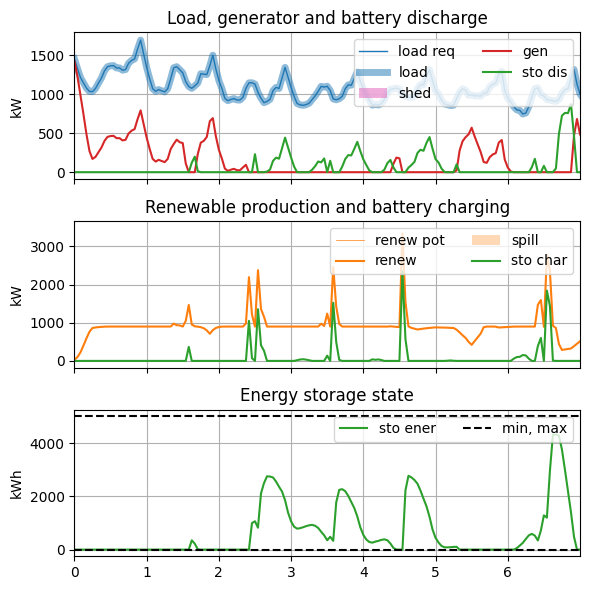

In [101]:
mgs.plotting.plot_oper_traj(microgrid, oper_traj)
plt.xlim(0,7)  # first 7 data points
plt.xticks(range(0, 7, 1))
##plt.xticks(np.arange(0, 365, step=7))
plt.show()

Zoom to one week in summer: much solar → battery often full → spillage

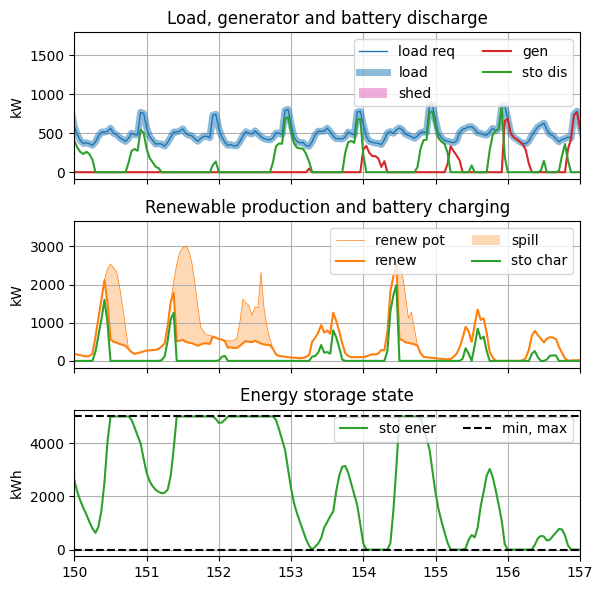

In [102]:
mgs.plotting.plot_oper_traj(microgrid, oper_traj)
plt.xlim(150,157) 

plt.show()

## Interactive simulation displays

Witness the effect of changing the rated power of the dispatchable Generator, Solar & Wind plants, and the Battery energy capacity
*(needs [ipywidgets](https://ipywidgets.readthedocs.io))*.

In [103]:
from ipywidgets import interactive

### Interactive energy mix

In [104]:
def interactive_mg(power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind):
    """Create `Microgrid` project description with generator, battery,
    and renewables (solar and wind) with given ratings"""
    generator = mgs.DispatchableGenerator(power_rated_gen,
        fuel_intercept, fuel_slope, fuel_price,
        investment_price_gen, om_price_gen,
        lifetime_gen
    )
    
    battery = mgs.Battery(energy_rated_sto,
        investment_price_sto, om_price_sto,
        lifetime_sto, lifetime_cycles,
        charge_rate, discharge_rate,
        loss_factor_sto)
    
    photovoltaic = mgs.Photovoltaic(power_rated_pv, irradiance,
        investment_price_pv, om_price_pv,
        lifetime_pv, derating_factor_pv)

    windgen = mgs.WindPower(power_rated_wind, cf_wind,
        investment_price_wind, om_price_wind,
        lifetime_wind)
    
    microgrid = mgs.Microgrid(project, Pload,
        generator, battery, {
        'Solar PV': photovoltaic,
        'Wind': windgen
    }
    )
    return microgrid

from functools import lru_cache

@lru_cache(maxsize=1000)
def simulate_microgrid(power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind):
    """Microgrid performance simulator, with calculation caching"""
    microgrid = interactive_mg(power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind)
    oper_stats = mgs.sim_operation(microgrid)
    mg_costs = mgs.sim_economics(microgrid, oper_stats)
    return oper_stats, mg_costs

def interactive_energy_mix(Generator=1800., Solar=0., Wind=0., Battery=0.):
    """display energy mix with given ratings"""
    # Translate variable names:
    power_rated_gen = Generator # kW
    energy_rated_sto = Battery # kWh
    power_rated_pv = Solar # kW
    power_rated_wind = Wind # kW
    # Create Microgrid project description
    microgrid = interactive_mg(power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind)
    # Simulate (with cache)
    oper_stats, mg_costs = simulate_microgrid(power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind)
    # Show some performance stats:
    print(f'Load shedding: {oper_stats.shed_rate:.1%}')
    print(f'Renewable: {oper_stats.renew_rate:.1%}')
    print(f'(Spilled renewable: {oper_stats.spilled_rate:.1%})')
    print(f'Levelized Cost of Electricity: {mg_costs.lcoe:.3f} $/kWh')
    
    # Display energy mix
    fig, (ax1, ax2) = plt.subplots(2,1, num=1, figsize=(6,6),
                                  gridspec_kw=dict(height_ratios=(2,1)))
    mgs.plotting.plot_ratings(microgrid, xlim=(-3.5,2.5), ylim=(-2.5,2.5), ax=ax1)
    mgs.plotting.plot_energy_mix(microgrid, oper_stats, ax=ax2)
    fig.tight_layout()
    plt.show()

This experiment starts from zero Solar power, Wind power and zero Battery energy, only using a large enough fuel-based Generator:

0. Observe first that if you undersize the generator below 1700 kW, without additional sources, you cannot perfectly supply the consumption
   (→ load shedding, significant for generator smaller than 1000 kW)
2. Start by first increasing Solar or Wind power alone
    - at first this reduce the usage of the Generator (see energy mix)
    - but beyond ~2000 kW (for Solar) or 1500 kW (for Wind), there is more and more *spilled energy*
3. Then, using 2000 kW of Solar and 2000 kW of Wind, increase Battery capacity to reduce spilled energy
    - at first, this reduces spilled energy and therefore reduces further generator usage
    - but beyond ~5000 kWh, it requires a higher and higher capacity to get an effect
4. Finally, with the extra Solar, Wind and Battery sources, you can slightly undersize the generator while still supplying the load
   
With appropriate settings, you should find a Levelized Cost of Electricity (LCOE) below 0.22\\$/kWh (while it is 0.35 \\$/kWh without Solar, Wind and Battery)
- You can also get a quite low LCOE with Wind alone or Solar alone (along with Generator and Storage).
  However, it's not as low as when Wind and Solar are used together → *Solar and Wind are very complementary*.

In [105]:
interactive(interactive_energy_mix,
            Generator=(0.0, 2000, 100),
            Solar=(0.0, 6000, 500),
            Wind=(0.0, 3000, 250),
            Battery=(0.0, 9000, 500))

interactive(children=(FloatSlider(value=1800.0, description='Generator', max=2000.0, step=100.0), FloatSlider(…

### Interactive trajectories

This experiment starts from an **undersized generator** (smaller than max load) and zero extra sources (Solar, Wind and Battery):
1. First see how increasing the generator power to 1800 kW easily increases the quality of service
   (reduce load shedding, in pink), but at a high cost of electricity (LCOE close to 0.35 \\$/kWh)
2. Then, add other sources (Solar, Wind and Battery) to reduce the LCOE to about 0.22 \\$/kWh
3. Finally, thanks to these extra sources, you can slightly undersized the Generator (1400 kW) and still get zero load shedding.
   - and this can shave an extra 0.01 \\$/kWh on the cost of electricity

In [106]:
def interactive_trajectories(Generator = 500., Solar=0., Wind=0., Battery=0., t_plot=60):
    """display trajectories with given ratings, zoomed at `t_plot`"""
    # Translate variable names:
    power_rated_gen = Generator # kW
    energy_rated_sto = Battery # kWh
    power_rated_pv = Solar # kW
    power_rated_wind = Wind # kW
    # Create Microgrid project description
    microgrid = interactive_mg(energy_rated_sto, power_rated_gen, power_rated_pv, power_rated_wind)
    # Simulate with trajectory recording
    oper_traj = mgs.TrajRecorder()
    oper_stats = mgs.sim_operation(microgrid, oper_traj)
    mg_costs = mgs.sim_economics(microgrid, oper_stats)
    # Show some performance stats:
    print(f'Gen Energy: {oper_stats.gen_energy:.0f}')
    print(f'Gen Fuel: {oper_stats.gen_fuel:.2f}')
    print(f'Gen Hours: {oper_stats.gen_hours:.0f}')
    print(f'Load shedding: {oper_stats.shed_rate:.1%}')
    print(f'Renewable: {oper_stats.renew_rate:.1%}')
    print(f'(Spilled renewable: {oper_stats.spilled_rate:.1%})')
    print(f'Levelized Cost of Electricity: {mg_costs.lcoe:.3f} $/kWh')
    # Display trajectories
    mgs.plotting.plot_oper_traj(microgrid, oper_traj)
    
    plt.xlim(t_plot, t_plot+30)
    plt.show()

interactive(interactive_trajectories,
            Generator = (0.0, 2000, 100),
            Solar=(0.0, 6000, 500), Wind=(0.0, 3000, 250), Battery=(0.0, 9000, 500),
            t_plot=(0.0, 365.-7, 30))

interactive(children=(FloatSlider(value=500.0, description='Generator', max=2000.0, step=100.0), FloatSlider(v…